In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install catboost

import os
import re
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.pyplot as plt
import ast

DATA_PATH = Path('/content/drive/MyDrive/Colab Notebooks/train_standardized.csv')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df = pd.read_csv(DATA_PATH, sep=',')

ARTIFACT_PATTERNS = [
    r'^\*\*.+\*\*',
    r'(identify|map|match|standardize|translate)\s+skills?',
    r'esco\s+(taxonomy|database|portal)',
    r'\b(step|determine|compare|list|use|instruction)\b',
    r'i can help map',
    r'once you have identified',
]

def is_artifact_skill(text: str) -> bool:
    if not text:
        return True
    s = str(text).lower().strip()
    for pat in ARTIFACT_PATTERNS:
        if re.search(pat, s):
            return True
    return False

# Загружаем JSON и чистим
json_file_path = '/content/drive/MyDrive/Colab Notebooks/unified_skills_mappings.json'
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        skills_data = json.load(f)
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути '{json_file_path}'")
    skills_data = {}

SKILL_MAP_FROM_JSON = {}
for original_skill, details in skills_data.items():
    key = original_skill.lower().strip()
    value = str(details.get('unified_skill', original_skill)).lower().strip()

    if is_artifact_skill(key) or is_artifact_skill(value):
        continue

    SKILL_MAP_FROM_JSON[key] = value

print(f"Загружено {len(SKILL_MAP_FROM_JSON)}")

# Словарь для ручной очистки оставшихся синонимов
MANUAL_SKILL_MAP = {
    'знание налогового учета': 'налоговый учет',
    'ведение налогового учета': 'налоговый учет',
    'владение компьютерная техника/оборудование': 'навыки работы с пк',
    'владение/пользователь пк': 'навыки работы с пк',
    'знание компьютерных и прочих программ': 'навыки работы с пк',
    'навыки работы с персональным компьютером': 'навыки работы с пк',
    'расчет и начисление заработной платы': 'расчет заработной платы',
    'ведение первичной документации': 'работа с первичной документацией',
    'обработка первичной документации': 'работа с первичной документацией',
    'первичная бухгалтерия': 'работа с первичной документацией',
    'знание бухгалтерского учета': 'бухгалтерский учет',
    'ведение бухгалтерского учета': 'бухгалтерский учет',
    'организация бухгалтерского учета': 'бухгалтерский учет',
    'опыт работы бухгалтером': 'бухгалтерский учет',
    'анализ тмц': 'учет тмц',
    'движение/перемещение тмц': 'учет тмц',
    'инвентаризация тмц': 'учет тмц',
    'комплектация тмц': 'учет тмц',
    'амортизация нма': 'учет нма',
    'инвентаризация нма': 'учет нма',
    'анализ затрат': 'управление затратами',
    'оптимизация затрат': 'управление затратами',
    'нормирование затрат': 'управление затратами',
    'планирование затрат': 'управление затратами',
    'зна': 'знания',
    'компь': 'навыки работы с пк',
    'бух': 'бухгалтерия',
}

def normalize_skill(text: str) -> str:
    s = str(text).lower().strip()
    s = re.sub(r'1[сc]', '1c', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip(' "\'«».,;:|')

    if is_artifact(s):
        return ""

    # JSON маппинг
    if s in SKILL_MAP_FROM_JSON:
        candidate = SKILL_MAP_FROM_JSON[s]
        if not is_artifact(candidate):
            s = candidate
        else:
            return ""

    # Ручной маппинг
    elif s in MANUAL_SKILL_MAP:
        s = MANUAL_SKILL_MAP[s]

    # Финальная фильтрация
    if is_artifact(s):
        return ""

    return s

def to_list_safe(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s in ("", "[]", "{}", "nan", "None"):
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except Exception:
        return re.split(r'[;\n\r|]+', s)

def explode_item(item: str):
    text = str(item)
    text = re.sub(r'на основе\s*esco\s*taxonomy:.*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+[—\-–]\s+', ' | ', text)
    text = re.sub(r'\s+\d{1,2}[.)]\s+', ' | ', text)
    text = re.sub(r'^\s*\d{1,2}[.)]\s+', '', text)
    text = re.sub(r'[;\n\r]+', ' | ', text)
    text = re.sub(r'\s*\|\s*', ' | ', text)
    parts = [p.strip() for p in text.split(' | ') if p.strip()]
    return parts

def clean_and_parse_skills(row):
    skill_source_columns = [
        'skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy',
        'standardize_skills_cv', 'combined_skills'
    ]
    raw_items = []
    for col in skill_source_columns:
        if col not in row.index:
            continue
        vals = row[col]
        seq = vals if isinstance(vals, list) else to_list_safe(vals)
        for it in seq:
            raw_items.extend(explode_item(it))

    skills = []
    for t in raw_items:
        t = normalize_skill(t)
        if not t:
            continue
        if len(t) < 2 or re.fullmatch(r'\d+', t):
            continue
        skills.append(t)

    return sorted(set(skills))


class IntervalCatBoostRegressor:
    def __init__(self, catboost_params=None):
        if catboost_params is None:
            catboost_params = {
                'iterations': 1000,
                'learning_rate': 0.05,
                'depth': 6,
                'loss_function': 'RMSE',
                'verbose': False
            }

        self.model_from = CatBoostRegressor(**catboost_params)
        self.model_to = CatBoostRegressor(**catboost_params)
        self.catboost_params = catboost_params

    def fit(self, X, y_from, y_to, cat_features=None, eval_set=None):

        self.model_from.fit(X, y_from, cat_features=cat_features, verbose=False)

        self.model_to.fit(X, y_to, cat_features=cat_features, verbose=False)

        return self

    def predict(self, X):

        y_from_pred = self.model_from.predict(X)
        y_to_pred = self.model_to.predict(X)

        y_from_corrected = np.minimum(y_from_pred, y_to_pred)
        y_to_corrected = np.maximum(y_from_pred, y_to_pred)

        return y_from_corrected, y_to_corrected

    def predict_point(self, X):

        y_from_pred, y_to_pred = self.predict(X)
        return 0.5 * (y_from_pred + y_to_pred)

    def calculate_interval_loss(self, X, y_from_true, y_to_true):

        y_from_pred, y_to_pred = self.predict(X)
        y_pred_mid = 0.5 * (y_from_pred + y_to_pred)

        under = np.maximum(0, y_from_true - y_pred_mid)
        over = np.maximum(0, y_pred_mid - y_to_true)
        interval_loss = np.mean(under + over)

        return interval_loss

    def calculate_metrics(self, X, y_from_true, y_to_true):

        y_from_pred, y_to_pred = self.predict(X)
        y_pred_mid = 0.5 * (y_from_pred + y_to_pred)
        y_true_mid = 0.5 * (y_from_true + y_to_true)

        interval_loss = self.calculate_interval_loss(X, y_from_true, y_to_true)
        mae = mean_absolute_error(y_true_mid, y_pred_mid)
        mape = np.mean(np.abs((y_true_mid - y_pred_mid) / np.maximum(y_true_mid, 1e-8))) * 100

        return {
            'interval_loss': interval_loss,
            'mae': mae,
            'mape': mape
        }

df["salary"] = df[["salaryMin_vacancy", "salaryMax_vacancy"]].mean(axis=1, skipna=True)
df = df[df["salary"].notna() & (df["salary"] > 0)].copy()

df['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("\nТип первого элемента в skills_list_clean:", type(df['skills_list_clean'].iloc[0]))

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom))

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

df['region'] = df['localityName'].fillna('Не указан')
df['date_published'] = pd.to_datetime(df['datePublished'], errors='coerce')
df['year_published'] = df['date_published'].dt.year
df['month_published'] = df['date_published'].dt.month
df['day_of_week_published'] = df['date_published'].dt.dayofweek

df['isQuoted'] = df['isQuoted'].fillna(False).astype(int)
df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)

df['scheduleType_vacancy'] = df['scheduleType_vacancy'].astype('category').cat.codes
df['companyBusinessSize'] = df['companyBusinessSize'].astype('category').cat.codes
df['needMedcard'] = df['needMedcard'].astype('category').cat.codes

df = df[df['skills_vacancy'].apply(lambda x: x != '[]' if pd.notna(x) else False)].copy()

def combine_skills(row):
    skills = []
    if pd.notna(row['skills_vacancy']) and row['skills_vacancy'] != '[]':
        skills.extend(eval(row['skills_vacancy']))
    if pd.notna(row['hardSkills_vacancy']) and row['hardSkills_vacancy'] != '[]':
        skills.extend(eval(row['hardSkills_vacancy']))
    if pd.notna(row['softSkills_vacancy']) and row['softSkills_vacancy'] != '[]':
        skills.extend(eval(row['softSkills_vacancy']))

    combined_skills = list(set([skill.lower() for skill in skills]))
    return combined_skills

df['combined_skills'] = df.apply(combine_skills, axis=1)

vacancy_columns = [
    'vacancyName', 'experienceRequirements', 'scheduleType_vacancy', 'needMedcard',
    'requiredDriveLicense', 'companyBusinessSize', 'isQuoted', 'isMobilityProgram',
    'qualifications', 'responsibilities', 'year_published',
    'month_published', 'day_of_week_published', "professionalSphereName"
]

existing_core_cols = [col for col in vacancy_columns if col in df.columns]
X = df[existing_core_cols].copy()

print("Обработка и нормализация навыков...")
X['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("Готово.")

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

skills_col = 'skills_list_clean'
mlb = MultiLabelBinarizer(sparse_output=False)

skills_binarized = mlb.fit_transform(X[skills_col])
skills_df = pd.DataFrame(skills_binarized, columns=mlb.classes_, index=X.index)

X_base = X.drop(columns=[skills_col])
raw_skill_columns_to_drop = ['combined_skills', 'skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy', 'standardize_skills_cv']
existing_raw_to_drop = [col for col in raw_skill_columns_to_drop if col in X_base.columns]
if existing_raw_to_drop:
    X_base = X_base.drop(columns=existing_raw_to_drop)
    print(f"Удалены сырые колонки с навыками: {existing_raw_to_drop}")

X_processed = pd.concat([X_base, skills_df], axis=1)

target_col = 'salary'
y = df[target_col].loc[X_processed.index]

print("\nФинальный DataFrame готов.")

cat_cols = []
text_cols = []

base_feature_columns = [col for col in X_processed.columns if col not in mlb.classes_]

for c in base_feature_columns:
    if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):
        avg_tokens = X_processed[c].astype(str).str.split().map(len).mean()
        if avg_tokens is not None and avg_tokens > 10:
            text_cols.append(c)
        else:
            cat_cols.append(c)

print("Категориальные колонки:", cat_cols)
print("Текстовые колонки для TF-IDF:", text_cols)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загружено 2479 правил из JSON после чистки.

Тип первого элемента в skills_list_clean: <class 'list'>


/tmp/ipython-input-3464574249.py:291: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)


Обработка и нормализация навыков...
Готово.

Финальный DataFrame готов.


/tmp/ipython-input-3464574249.py:357: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):
/tmp/ipython-input-3464574249.py:357: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):


Категориальные колонки: ['vacancyName', 'requiredDriveLicense', 'professionalSphereName']
Текстовые колонки для TF-IDF: ['qualifications', 'responsibilities']


/tmp/ipython-input-3464574249.py:357: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):


In [ ]:
suspicious = [(k,v) for k,v in SKILL_MAP_FROM_JSON.items() if is_artifact(v) or is_artifact(k)]
print(f"Найдено подозрительных маппингов: {len(suspicious)}")
print("Примеры:")
for k,v in suspicious:
    print("Оригинал:", k, "→", v)

Найдено подозрительных маппингов: 0
Примеры:


Дублирующихся колонок не найдено.

=== Обучение обычного CatBoost ===
0:	learn: 0.4506607	test: 0.4498989	best: 0.4498989 (0)	total: 855ms	remaining: 17m 5s
100:	learn: 0.2800976	test: 0.2815133	best: 0.2815133 (100)	total: 1m 20s	remaining: 14m 35s
200:	learn: 0.2556910	test: 0.2636018	best: 0.2636018 (200)	total: 2m 40s	remaining: 13m 16s
300:	learn: 0.2327363	test: 0.2497671	best: 0.2497671 (300)	total: 4m 1s	remaining: 12m 2s
400:	learn: 0.2144150	test: 0.2396273	best: 0.2396273 (400)	total: 5m 30s	remaining: 10m 57s
500:	learn: 0.1999104	test: 0.2323574	best: 0.2323574 (500)	total: 6m 50s	remaining: 9m 33s
600:	learn: 0.1879026	test: 0.2267787	best: 0.2267787 (600)	total: 8m 10s	remaining: 8m 9s
700:	learn: 0.1773143	test: 0.2216219	best: 0.2216167 (699)	total: 9m 31s	remaining: 6m 47s
800:	learn: 0.1680096	test: 0.2173190	best: 0.2173190 (800)	total: 10m 51s	remaining: 5m 24s
900:	learn: 0.1602428	test: 0.2142429	best: 0.2142429 (900)	total: 12m 12s	remaining: 4m 3s
1000:	learn: 

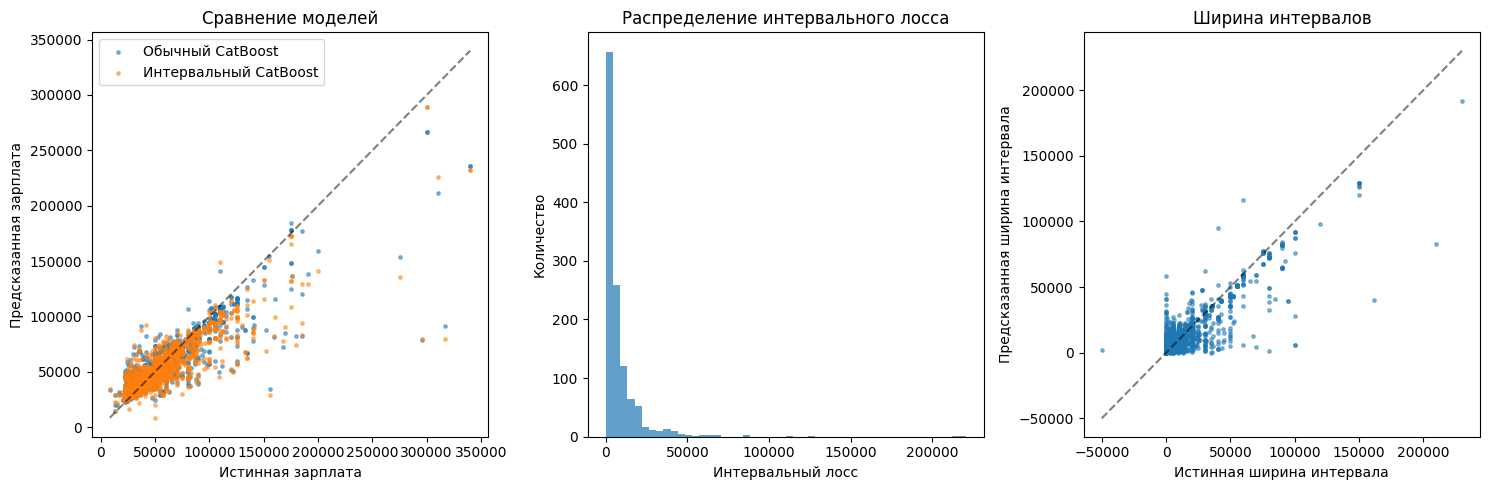


=== K-fold валидация интервальной модели ===
Fold 1: Interval Loss=0.11, MAE=0.17, MAPE=1.56%
Fold 2: Interval Loss=0.14, MAE=0.17, MAPE=1.61%
Fold 3: Interval Loss=0.13, MAE=0.17, MAPE=1.67%
Fold 4: Interval Loss=0.13, MAE=0.17, MAPE=1.61%
Fold 5: Interval Loss=0.13, MAE=0.17, MAPE=1.63%

KFold Interval Loss: 0.13 ± 0.01
KFold MAE: 0.17 ± 0.00
KFold MAPE: 1.62% ± 0.03%


In [ ]:
USE_LOG_TARGET = True
if USE_LOG_TARGET:
    y_transformed = np.log(np.maximum(y, 1.0))
else:
    y_transformed = y.copy()

y_from = df['salaryMin_vacancy'].loc[X_processed.index]
y_to = df['salaryMax_vacancy'].loc[X_processed.index]

if USE_LOG_TARGET:
    y_from_transformed = np.log(np.maximum(y_from, 1.0))
    y_to_transformed = np.log(np.maximum(y_to, 1.0))
else:
    y_from_transformed = y_from.copy()
    y_to_transformed = y_to.copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X_processed, y_transformed, test_size=0.2, random_state=RANDOM_STATE
)

y_train_from = y_from_transformed.loc[X_train.index]
y_train_to = y_to_transformed.loc[X_train.index]
y_valid_from = y_from_transformed.loc[X_valid.index]
y_valid_to = y_to_transformed.loc[X_valid.index]

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vecs = {}
X_train_num = X_train.copy()
X_valid_num = X_valid.copy()

for col in text_cols:
    vec = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=5)
    Xt = vec.fit_transform(X_train[col].fillna(""))
    Xv = vec.transform(X_valid[col].fillna(""))

    tf_cols = [f"{col}__tfidf_{i}" for i in range(Xt.shape[1])]
    X_train_tfidf = pd.DataFrame(Xt.toarray(), index=X_train.index, columns=tf_cols)
    X_valid_tfidf = pd.DataFrame(Xv.toarray(), index=X_valid.index, columns=tf_cols)

    X_train_num = pd.concat([X_train_num.drop(columns=[col]), X_train_tfidf], axis=1)
    X_valid_num = pd.concat([X_valid_num.drop(columns=[col]), X_valid_tfidf], axis=1)
    tfidf_vecs[col] = vec

duplicates = X_train_num.columns[X_train_num.columns.duplicated()]
if not duplicates.empty:
    print("Найдены дублирующиеся колонки:")
    print(duplicates.unique().tolist())
else:
    print("Дублирующихся колонок не найдено.")

new_cat_cols = [c for c in cat_cols if c in X_train_num.columns]
new_text_cols = []
new_num_cols = [c for c in X_train_num.columns if c not in new_cat_cols]

def make_pool_num(X_df, y_vec=None):
    feature_names = list(X_df.columns)
    cat_idxs = [feature_names.index(c) for c in new_cat_cols if c in feature_names]
    return Pool(
        data=X_df,
        label=y_vec,
        cat_features=cat_idxs if cat_idxs else None,
        feature_names=feature_names,
    )

train_pool_num = make_pool_num(X_train_num, y_train)
valid_pool_num = make_pool_num(X_valid_num, y_valid)

from catboost.utils import get_gpu_device_count
gpu_ok = (get_gpu_device_count() > 0)

params = dict(
    loss_function='RMSE',
    depth=8,
    iterations=1200,
    learning_rate=0.045,
    random_seed=RANDOM_STATE,
    od_type='Iter',
    od_wait=50,
    verbose=100,
    task_type='GPU' if gpu_ok else 'CPU'
)

print("\n=== Обучение обычного CatBoost ===")
model = CatBoostRegressor(**params)
model.fit(train_pool_num, eval_set=valid_pool_num)

def inv_transform(yhat):
    if USE_LOG_TARGET:
        return np.exp(yhat)
    return yhat

yhat_valid_t = model.predict(valid_pool_num)
yhat_valid = inv_transform(yhat_valid_t)
y_valid_orig = np.exp(y_valid) if USE_LOG_TARGET else y_valid

print("\nValidation RMSE:", rmse(y_valid_orig, yhat_valid))
print("Validation MAPE:", mape(y_valid_orig, yhat_valid))

interval_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'verbose': 100,
    'random_seed': RANDOM_STATE,
    'task_type': 'GPU' if gpu_ok else 'CPU'
}

interval_model = IntervalCatBoostRegressor(interval_params)

train_pool_from = make_pool_num(X_train_num, y_train_from)
train_pool_to = make_pool_num(X_train_num, y_train_to)

interval_model.fit(X_train_num, y_train_from, y_train_to, cat_features=new_cat_cols)

y_pred_from, y_pred_to = interval_model.predict(X_valid_num)
y_pred_interval = interval_model.predict_point(X_valid_num)

if USE_LOG_TARGET:
    y_pred_interval = np.exp(y_pred_interval)
    y_pred_from = np.exp(y_pred_from)
    y_pred_to = np.exp(y_pred_to)
    y_valid_from_orig = np.exp(y_valid_from)
    y_valid_to_orig = np.exp(y_valid_to)
else:
    y_valid_from_orig = y_valid_from
    y_valid_to_orig = y_valid_to

y_valid_mid_orig = 0.5 * (y_valid_from_orig + y_valid_to_orig)

print(f"RMSE (точечное предсказание): {rmse(y_valid_mid_orig, y_pred_interval):.2f}")
print(f"MAE (точечное предсказание): {mean_absolute_error(y_valid_mid_orig, y_pred_interval):.2f}")
print(f"MAPE (точечное предсказание): {mape(y_valid_mid_orig, y_pred_interval):.2f}%")

under = np.maximum(0, y_valid_from_orig - y_pred_interval)
over = np.maximum(0, y_pred_interval - y_valid_to_orig)
interval_loss_valid = np.mean(under + over)
print(f"Интервальный лосс на валидации: {interval_loss_valid:.2f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_valid_orig, yhat_valid, s=6, alpha=0.5, label='Обычный CatBoost')
plt.scatter(y_valid_mid_orig, y_pred_interval, s=6, alpha=0.5, label='Интервальный CatBoost')
plt.xlabel("Истинная зарплата")
plt.ylabel("Предсказанная зарплата")
plt.title("Сравнение моделей")
plt.plot([y_valid_orig.min(), y_valid_orig.max()],
         [y_valid_orig.min(), y_valid_orig.max()], 'k--', alpha=0.5)
plt.legend()

plt.subplot(1, 3, 2)
under_valid = np.maximum(0, y_valid_from_orig - y_pred_interval)
over_valid = np.maximum(0, y_pred_interval - y_valid_to_orig)
total_loss = under_valid + over_valid
plt.hist(total_loss[total_loss > 0], bins=50, alpha=0.7)
plt.xlabel("Интервальный лосс")
plt.ylabel("Количество")
plt.title("Распределение интервального лосса")

plt.subplot(1, 3, 3)
true_width = y_valid_to_orig - y_valid_from_orig
pred_width = y_pred_to - y_pred_from
plt.scatter(true_width, pred_width, s=6, alpha=0.5)
plt.xlabel("Истинная ширина интервала")
plt.ylabel("Предсказанная ширина интервала")
plt.title("Ширина интервалов")
plt.plot([true_width.min(), true_width.max()],
         [true_width.min(), true_width.max()], 'k--', alpha=0.5)

plt.tight_layout()
plt.show()

def predict_salary_processed(df_processed):
    model_features = train_pool_num.get_feature_names()
    df_processed = df_processed[model_features]
    pool = make_pool_num(df_processed, None)
    yhat_t = model.predict(pool)
    return inv_transform(yhat_t)

def predict_salary_interval(df_processed, model):
    """Предсказание с использованием интервальной модели"""
    return model.predict_point(df_processed)

def kfold_interval_experiment(X_df, y_from, y_to, n_splits=5):
    """K-fold кросс-валидация для интервальной модели"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    interval_losses = []
    maes = []
    mapes = []

    from sklearn.feature_extraction.text import TfidfVectorizer

    for i, (tr, va) in enumerate(kf.split(X_df), 1):
        X_tr_raw, X_va_raw = X_df.iloc[tr].copy(), X_df.iloc[va].copy()
        y_from_tr, y_from_va = y_from.iloc[tr], y_from.iloc[va]
        y_to_tr, y_to_va = y_to.iloc[tr], y_to.iloc[va]

        X_tr, X_va = X_tr_raw.copy(), X_va_raw.copy()

        for col in text_cols:
            if col in X_tr.columns:
                vec = TfidfVectorizer(max_features=800, ngram_range=(1,2), min_df=5)
                Xt = vec.fit_transform(X_tr[col].fillna(""))
                Xv = vec.transform(X_va[col].fillna(""))

                tf_cols = [f"{col}__tfidf_{j}" for j in range(Xt.shape[1])]
                X_tr_tfidf = pd.DataFrame(Xt.toarray(), index=X_tr.index, columns=tf_cols)
                X_va_tfidf = pd.DataFrame(Xv.toarray(), index=X_va.index, columns=tf_cols)

                X_tr = pd.concat([X_tr.drop(columns=[col]), X_tr_tfidf], axis=1)
                X_va = pd.concat([X_va.drop(columns=[col]), X_va_tfidf], axis=1)

        fold_cat_cols = [c for c in cat_cols if c in X_tr.columns]

        fold_model = IntervalCatBoostRegressor({
            'iterations': 500,
            'learning_rate': 0.05,
            'depth': 6,
            'verbose': False,
            'random_seed': RANDOM_STATE
        })
        fold_model.fit(X_tr, y_from_tr, y_to_tr, cat_features=fold_cat_cols)

        metrics = fold_model.calculate_metrics(X_va, y_from_va, y_to_va)
        interval_losses.append(metrics['interval_loss'])
        maes.append(metrics['mae'])
        mapes.append(metrics['mape'])

        print(f"Fold {i}: Interval Loss={interval_losses[-1]:.2f}, "
              f"MAE={maes[-1]:.2f}, MAPE={mapes[-1]:.2f}%")

    print(f"\nKFold Interval Loss: {np.mean(interval_losses):.2f} ± {np.std(interval_losses):.2f}")
    print(f"KFold MAE: {np.mean(maes):.2f} ± {np.std(maes):.2f}")
    print(f"KFold MAPE: {np.mean(mapes):.2f}% ± {np.std(mapes):.2f}%")

print("\n=== K-fold валидация интервальной модели ===")
kfold_interval_experiment(X_processed, y_from_transformed, y_to_transformed, n_splits=5)



In [ ]:

results_summary = []

results_summary.append({
    'Модель': 'CatBoost (точечный)',
    'RMSE': rmse(y_valid_orig, yhat_valid),
    'MAE': mean_absolute_error(y_valid_orig, yhat_valid),
    'MAPE': mape(y_valid_orig, yhat_valid),
    'Интервальный лосс': np.nan
})

results_summary.append({
    'Модель': 'CatBoost (интервальный)',
    'RMSE': rmse(y_valid_mid_orig, y_pred_interval),
    'MAE': mean_absolute_error(y_valid_mid_orig, y_pred_interval),
    'MAPE': mape(y_valid_mid_orig, y_pred_interval),
    'Интервальный лосс': interval_loss_valid
})

summary_df = pd.DataFrame(results_summary)
print("\nСравнение моделей на валидационной выборке:")
display(summary_df.style.format({
    'RMSE': '{:.2f}',
    'MAE': '{:.2f}',
    'MAPE': '{:.2f}',
    'Интервальный лосс': '{:.2f}'
}, na_rep='-'))


=== Итоговая сводная таблица результатов ===

Сравнение моделей на валидационной выборке:


,Модель,RMSE,MAE,MAPE,Интервальный лосс
0,CatBoost (точечный),15028.11,7026.20,0.13,-
1,CatBoost (интервальный),16151.39,8293.30,0.15,4860.38


In [ ]:
results_df_interval = pd.DataFrame({
    'true_from': y_valid_from_orig,
    'true_to': y_valid_to_orig,
    'true_mid': y_valid_mid_orig,
    'pred_from': y_pred_from,
    'pred_to': y_pred_to,
    'pred_mid': y_pred_interval,
    'industry': X_valid["professionalSphereName"]
})

def calculate_metrics_by_sphere(data_subset):
    """Рассчитывает метрики для подмножества данных"""
    mae_point = np.mean(np.abs(data_subset['true_mid'] - data_subset['pred_mid']))

    under = np.maximum(0, data_subset['true_from'] - data_subset['pred_mid'])
    over = np.maximum(0, data_subset['pred_mid'] - data_subset['true_to'])
    interval_loss = np.mean(under + over)

    true_width = np.mean(data_subset['true_to'] - data_subset['true_from'])
    pred_width = np.mean(data_subset['pred_to'] - data_subset['pred_from'])

    return {
        'MAE': mae_point,
        'Интервальный лосс': interval_loss,
        'Средняя истинная ширина': true_width,
        'Средняя предсказанная ширина': pred_width,
        'Количество': len(data_subset)
    }

report_data_spheres = []

full_metrics = calculate_metrics_by_sphere(results_df_interval)
full_metrics['Сфера'] = 'Все сферы'
report_data_spheres.append(full_metrics)

unique_spheres = results_df_interval['industry'].unique()

for sphere in unique_spheres:
    sphere_subset = results_df_interval[results_df_interval['industry'] == sphere]

    if len(sphere_subset) < 5:
        continue

    sphere_metrics = calculate_metrics_by_sphere(sphere_subset)
    sphere_metrics['Сфера'] = sphere
    report_data_spheres.append(sphere_metrics)

report_df_spheres = pd.DataFrame(report_data_spheres)
report_df_spheres = report_df_spheres.set_index('Сфера')
report_df_spheres = report_df_spheres.sort_values('MAE')

print("\nТаблица — Результаты интервального CatBoost по профессиональным сферам:")
display(report_df_spheres.style.format({
    'MAE': '{:.1f}',
    'Интервальный лосс': '{:.1f}',
    'Средняя истинная ширина': '{:.1f}',
    'Средняя предсказанная ширина': '{:.1f}',
    'Количество': '{:d}'
}))

print("\n=== Анализ влияния навыков (интервальная модель) ===")

def analyze_skill_impact_interval(skill_name, X_df, model):
    """Анализ влияния навыка на предсказание интервала"""
    if skill_name not in X_df.columns:
        return None

    X_with = X_df.copy()
    X_without = X_df.copy()
    X_with[skill_name] = 1
    X_without[skill_name] = 0

    y_with = model.predict_point(X_with)
    y_without = model.predict_point(X_without)

    avg_impact = np.mean(y_with - y_without)

    from_with, to_with = model.predict(X_with)
    from_without, to_without = model.predict(X_without)
    width_with = to_with - from_with
    width_without = to_without - from_without
    avg_width_impact = np.mean(width_with - width_without)

    return {
        'skill': skill_name,
        'avg_salary_impact': avg_impact,
        'avg_width_impact': avg_width_impact
    }

skill_impacts = []
skills_to_analyze = [s for s in mlb.classes_ if s in X_valid_num.columns][:50]

for skill in skills_to_analyze:
    impact = analyze_skill_impact_interval(skill, X_valid_num, interval_model)
    if impact:
        skill_impacts.append(impact)

skill_impacts_df = pd.DataFrame(skill_impacts)
skill_impacts_df = skill_impacts_df.sort_values('avg_salary_impact', ascending=False)

print("\nТоп-10 навыков по влиянию на зарплату (интервальная модель):")
display(skill_impacts_df.head(10))

print("\nТоп-10 навыков, увеличивающих неопределенность (ширину интервала):")
display(skill_impacts_df.sort_values('avg_width_impact', ascending=False).head(10))


def get_skill_impact_regular(skill_name, X_df):
    if skill_name not in X_df.columns:
        return None

    df_minus = X_df.copy()
    df_plus = X_df.copy()
    df_minus[skill_name] = 0
    df_plus[skill_name] = 1

    preds_minus = predict_salary_processed(df_minus)
    preds_plus = predict_salary_processed(df_plus)

    avg_value = np.mean(preds_plus - preds_minus)
    return avg_value

comparison_data = []
for skill in skills_to_analyze[:20]:
    regular_impact = get_skill_impact_regular(skill, X_valid_num)
    interval_data = skill_impacts_df[skill_impacts_df['skill'] == skill]

    if regular_impact is not None and not interval_data.empty:
        comparison_data.append({
            'Навык': skill,
            'Влияние (обычная модель)': regular_impact,
            'Влияние (интервальная модель)': interval_data.iloc[0]['avg_salary_impact'],
            'Влияние на ширину интервала': interval_data.iloc[0]['avg_width_impact']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Влияние (интервальная модель)', ascending=False)

print("\nСравнение влияния навыков между моделями:")
display(comparison_df.style.format({
    'Влияние (обычная модель)': '{:.0f}',
    'Влияние (интервальная модель)': '{:.0f}',
    'Влияние на ширину интервала': '{:.0f}'
}))

print(f"\nОбычная модель CatBoost:")
print(f"  - RMSE: {rmse(y_valid_orig, yhat_valid):.2f}")
print(f"  - MAE: {mean_absolute_error(y_valid_orig, yhat_valid):.2f}")
print(f"  - MAPE: {mape(y_valid_orig, yhat_valid):.2f}%")

print(f"\nИнтервальная модель CatBoost:")
print(f"  - RMSE: {rmse(y_valid_mid_orig, y_pred_interval):.2f}")
print(f"  - MAE: {mean_absolute_error(y_valid_mid_orig, y_pred_interval):.2f}")
print(f"  - MAPE: {mape(y_valid_mid_orig, y_pred_interval):.2f}%")
print(f"  - Интервальный лосс: {interval_loss_valid:.2f}")
print(f"  - Средняя ширина предсказанного интервала: {np.mean(pred_width):.2f}")
print(f"  - Доля предсказаний в истинном интервале: {np.mean((y_pred_interval >= y_valid_from_orig) & (y_pred_interval <= y_valid_to_orig))*100:.1f}%")


Таблица — Результаты интервального CatBoost по профессиональным сферам:


,MAE,Интервальный лосс,Средняя истинная ширина,Средняя предсказанная ширина,Количество
Сфера,,,,,
"Государственная служба, некоммерческие организации",4497.6,2297.7,10383.1,9850.0,134
Пищевая промышленность,5158.1,2899.6,8766.7,10425.4,61
Юриспруденция,5202.1,2639.7,6011.5,5388.8,61
"Административная работа, секретариат, АХО",5207.5,3893.7,4171.3,4050.7,126
"Безопасность, службы охраны",5451.3,2201.0,8582.6,12467.8,19
"Кадровая служба, управление персоналом",6705.7,4864.8,6900.9,7111.5,36
Легкая промышленность,6709.6,1419.3,44307.7,40629.8,26
"Сельское хозяйство, экология, ветеринария",6729.0,4778.0,6336.3,7295.0,19
"Бухгалтерия, налоги, управленческий учет",6750.1,3981.4,9771.3,12206.6,197



=== Анализ влияния навыков (интервальная модель) ===

Топ-10 навыков по влиянию на зарплату (интервальная модель):


,skill,avg_salary_impact,avg_width_impact
24,1c: зарплата и управление персоналом (зуп) / 1...,0.039887,-0.038457
0,-умение конфигурировать управляемые коммутатор...,0.000000,0.000000
2,1 с,0.000000,0.000000
3,1 с 8 предприятие,0.000000,0.000000
4,1c,0.000000,0.000000
5,1c (программы семейства 1c),0.000000,0.000000
6,1c proficiency,0.000000,0.000000
7,1c бухгалтерия,0.000000,0.000000
8,1c документооборот,0.000000,0.000000
9,1c зарплата и кадры,0.000000,0.000000



Топ-10 навыков, увеличивающих неопределенность (ширину интервала):


,skill,avg_salary_impact,avg_width_impact
0,-умение конфигурировать управляемые коммутатор...,0.0,0.0
2,1 с,0.0,0.0
10,1c зуп,0.0,0.0
3,1 с 8 предприятие,0.0,0.0
4,1c,0.0,0.0
5,1c (программы семейства 1c),0.0,0.0
6,1c proficiency,0.0,0.0
7,1c бухгалтерия,0.0,0.0
8,1c документооборот,0.0,0.0
9,1c зарплата и кадры,0.0,0.0



=== Сравнение влияния навыков: обычная vs интервальная модель ===

Сравнение влияния навыков между моделями:


,Навык,Влияние (обычная модель),Влияние (интервальная модель),Влияние на ширину интервала
0,-умение конфигурировать управляемые коммутаторы 2 и 3 уровня,0,0,0
1,1 год,0,0,0
2,1 с,0,0,0
3,1 с 8 предприятие,0,0,0
4,1c,0,0,0
5,1c (программы семейства 1c),0,0,0
6,1c proficiency,0,0,0
7,1c бухгалтерия,0,0,0
8,1c документооборот,0,0,0
9,1c зарплата и кадры,0,0,0



=== ИТОГОВАЯ СВОДКА ===

Обычная модель CatBoost:
  - RMSE: 14919.69
  - MAE: 7086.81
  - MAPE: 0.13%

Интервальная модель CatBoost:
  - RMSE: 16134.02
  - MAE: 8295.62
  - MAPE: 0.15%
  - Интервальный лосс: 4858.09
  - Средняя ширина предсказанного интервала: 13280.03
  - Доля предсказаний в истинном интервале: 40.1%
